## Импорт необходимых библиотек

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import importlib
import matplotlib.pyplot as plt
import random
from transformers import SegformerForSemanticSegmentation
from utils import functions
importlib.reload(functions)

<module 'utils.functions' from 'C:\\Users\\Raindow\\Desktop\\СПБГУ\\utils\\functions.py'>

## Конфигурация PyTorch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


## Конфигурация модели

In [5]:
# Конфигурация
DATA_PATH = "dataset" # Путь датасета
BATCH_SIZE = 16 # Размер батча
EPOCHS = 100 # Количество эпох
LR = 0.001 # Learning rate
IMG_SIZE = 256 # Размер входных изображений

## Класс, описывающий датасет

In [6]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


## Аугментация данных

In [7]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

## Загрузка датасета

In [8]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [9]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)


## Разделение на обучающую и тестовую выборку, загрузка данных

In [10]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

# Создание подмножеств из полного датасета
train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

# Создание DataLoader для батчевой загрузки данных
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Обучение SegFormer

In [11]:
# Проверка устройства для обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b4", num_labels=1)

# Перенос модели на GPU
print(device)
modified_model = model.to(device)

# Вес для положительного класса
pos_weight = torch.tensor([10.0]).to(device)

# Функция потерь с учетом веса
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Оптимизатор
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

# Обучение
for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images).logits
        
        # Увеличиваем размер выходных данных до размера масок
        outputs = torch.nn.functional.interpolate(
            outputs, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False
        )
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images).logits
            
            # Увеличиваем размер выходных данных до размера масок
            outputs = torch.nn.functional.interpolate(
                outputs, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False
            )
            
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    # Получение метрик
    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    # Присоединение метрик к спикам
    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    # Вывод метрик эпохи
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")

    # Сохранение весов модели при условии наилучших метрик на эпохе
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "segformer_final.pth")
        print(f"Best model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")



Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda
Epoch 1/100
Train Loss: 0.4994 | Test Loss: 0.4413
IoU: 0.7460 | Dice: 0.7536
------------------------
Best model saved at epoch 1 with IoU: 0.7460
Epoch 2/100
Train Loss: 0.4571 | Test Loss: 0.4969
IoU: 0.7360 | Dice: 0.7478
------------------------
Epoch 3/100
Train Loss: 0.4539 | Test Loss: 0.4185
IoU: 0.7551 | Dice: 0.7624
------------------------
Best model saved at epoch 3 with IoU: 0.7551
Epoch 4/100
Train Loss: 0.4439 | Test Loss: 0.4401
IoU: 0.7725 | Dice: 0.7725
------------------------
Best model saved at epoch 4 with IoU: 0.7725
Epoch 5/100
Train Loss: 0.4460 | Test Loss: 0.4458
IoU: 0.7631 | Dice: 0.7650
------------------------
Epoch 6/100
Train Loss: 0.4402 | Test Loss: 0.4157
IoU: 0.7664 | Dice: 0.7674
------------------------
Epoch 7/100
Train Loss: 0.4387 | Test Loss: 0.4197
IoU: 0.7598 | Dice: 0.7664
------------------------
Epoch 8/100
Train Loss: 0.4377 | Test Loss: 0.4201
IoU: 0.7725 | Dice: 0.7725
------------------------
Epoch 9/100
Train Loss: 0.4360 | Tes

## Графики

## Train/test losses

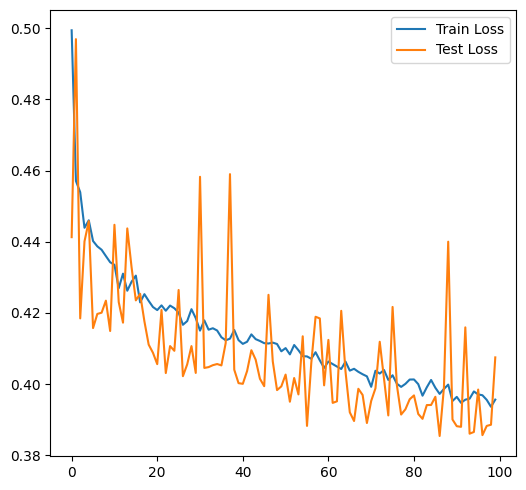

In [12]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

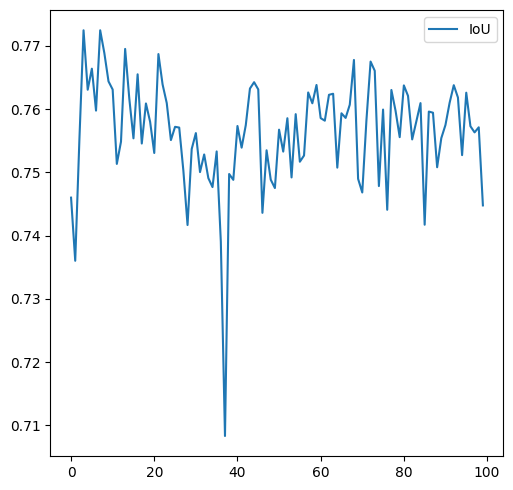

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

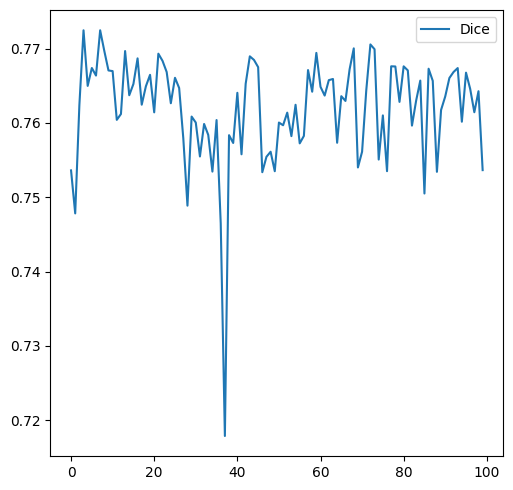

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

## Примеры результатов сегментации

В качестве примеров были выбраны изображения с "неоднозначным" расположением следов от дренажных труб для демонстрации способности модели выделять целевой класс в условиях низкой контрастности между пикселями фона и дренажных труб.

In [257]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
from transformers import SegformerForSemanticSegmentation


# Пути к изображениям
image_path_1 = "image_4215.png"
image_path_2 = "1.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Функция по загрузке и преобразованию изображения
def preprocess_image(image_path, img_size=(256, 256)):
    image = Image.open(image_path).convert("RGB")  # RGB формат
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0) 
    return image

In [23]:
image = preprocess_image(image_path_2).to(device)

# Инициализация модели 
segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b4", num_labels=1).to(device)
segformer_model.load_state_dict(torch.load("segformer_test.pth"))
segformer_model.eval()

segformer_outputs = segformer_model(image).logits
segformer_outputs = torch.nn.functional.interpolate(
segformer_outputs, size=(256, 256), mode="bilinear", align_corners=False)

with torch.no_grad():
     pred_mask = torch.sigmoid(segformer_outputs).squeeze().cpu().numpy()
     pred_mask = (pred_mask > 0.5).astype(np.uint8)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


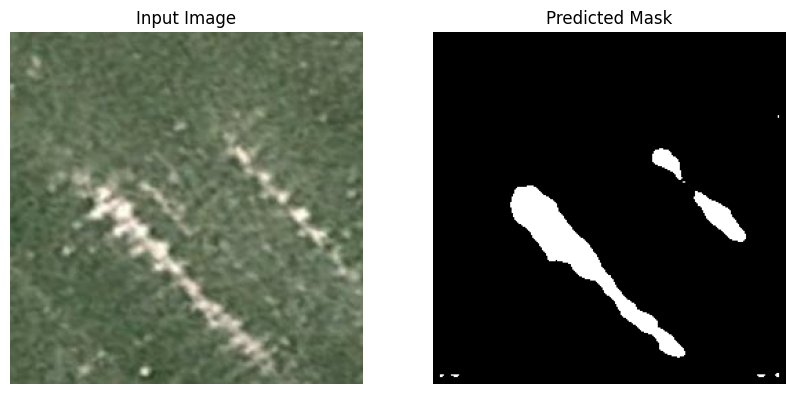

In [291]:
# Отображение исходного изображения и маски
plt.figure(figsize=(10, 5))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path_2))
plt.title("Input Image")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [132]:
image = preprocess_image(image_path_1).to(device)

# Инициализация модели 
segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b4", num_labels=1).to(device)
segformer_model.load_state_dict(torch.load("segformer_test.pth"))
segformer_model.eval()

segformer_outputs = segformer_model(image).logits
segformer_outputs = torch.nn.functional.interpolate(
segformer_outputs, size=(256, 256), mode="bilinear", align_corners=False)

with torch.no_grad():
     pred_mask = torch.sigmoid(segformer_outputs).squeeze().cpu().numpy()
     pred_mask = (pred_mask > 0.5).astype(np.uint8)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


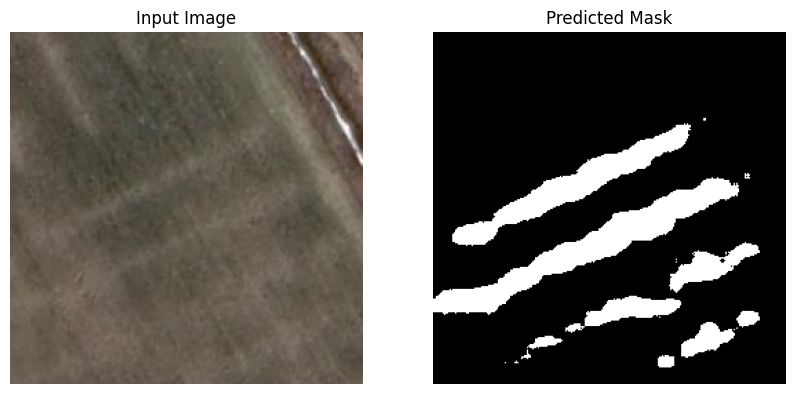

In [137]:
# Отображение исходного изображения и маски
plt.figure(figsize=(10, 5))

# Исходное изображение
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path_1))
plt.title("Input Image")
plt.axis("off")

# Предсказанная маска
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()